In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [2]:
import torch
from PIL import Image
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from HF_dataset import HFDataset
import json
import os
from tqdm import tqdm
import logging
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
model.to(device)
model.eval()

def encode_text(text):
    with torch.no_grad():
        text_tokens = clip.tokenize([text]).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

def encode_image(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

def cosine_similarity(image_features, text_features):
    return (image_features @ text_features.T).item()

def cosine_distance(image_features, text_features):
    return 1 - cosine_similarity(image_features, text_features)


In [5]:
def get_sample_embeddings(samples, dataset, output_file):
    img_embeddings = []
    for key in tqdm(samples, desc=f"Processing {output_file}"):
        image, text = dataset.get_by_id(key)
        image = preprocess(image).unsqueeze(0).to(device)
        image_features = encode_image(image)
        # text_features = encode_text(text)
        img_embeddings.append(image_features.cpu().numpy().tolist())

    with open(output_file, "w") as f:
        json.dump(img_embeddings, f)

def process_dataset(dataset_name, lookup_file):
    dataset_dir = f"data/optimized_dataset/{dataset_name}"
    if not os.path.exists(dataset_dir):
        # try another path
        dataset_dir_alt = f"/teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/{dataset_name}"
        if not os.path.exists(dataset_dir_alt):
            logger.warning(f"Dataset path not found: {dataset_dir_alt}")
            return
        else:
            dataset_dir = dataset_dir_alt

    try:
        with open(lookup_file, "r") as f:
            lookup = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        logger.warning(f"Invalid lookup file: {lookup_file}")
        return

    dataset = HFDataset(dataset_dir, "index.json", lookup)

    # Process one_copy
    one_copy_file = f"filtered_results_all/{dataset_name}-one_copy.json"
    output_one_copy = f"filtered_results_all/img_embeddings-clip/one_copy/{dataset_name}-one_copy.json"

    if not os.path.exists(output_one_copy):
        if os.path.exists(one_copy_file):
            with open(one_copy_file, "r") as f:
                one_copy = json.load(f)
            get_sample_embeddings(one_copy.keys(), dataset, output_one_copy)
        else:
            logger.warning(f"One copy file missing: {one_copy_file}")
    else:
        logger.info(f"Skipping processed one copy: {output_one_copy}")

    # Process multiple_copy
    multiple_copy_file = f"filtered_results_all/{dataset_name}-multiple_copy.json"
    output_multiple_copy = f"filtered_results_all/img_embeddings-clip/multiple_copy/{dataset_name}-multiple_copy.json"

    if not os.path.exists(output_multiple_copy):
        if os.path.exists(multiple_copy_file):
            with open(multiple_copy_file, "r") as f:
                multiple_copy = json.load(f)
            get_sample_embeddings(multiple_copy.keys(), dataset, output_multiple_copy)
        else:
            logger.warning(f"Multiple copy file missing: {multiple_copy_file}")
    else:
        logger.info(f"Skipping processed multiple copy: {output_multiple_copy}")

In [6]:
    dataset_names = ["imagenet-a", "imagenet-o","imagenet-r", "cifar100", "caltech101", "cars", "aircraft", "country211", "fer2013", "food101", "imagenetv2", "pets", "sun397"]
    dataset_list = [(dataset_name, f"data/classes_{dataset_name}.json") for dataset_name in dataset_names]
    lookup_files = [f"classes_{name}.json" for name in dataset_list]
    splits = ["train", "test"]

    for dataset_name, lookup_file in dataset_list:
        for split in splits:
            process_dataset(f"{dataset_name}-{split}", lookup_file)

2025-03-05 18:06:53,890 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/imagenet-a-train
2025-03-05 18:06:54,035 - INFO - Skipping processed one copy: filtered_results_all/img_embeddings-clip/one_copy/imagenet-a-test-one_copy.json
Processing filtered_results_all/img_embeddings-clip/multiple_copy/imagenet-a-test-multiple_copy.json: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]
2025-03-05 18:06:55,537 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/imagenet-o-train
Processing filtered_results_all/img_embeddings-clip/one_copy/imagenet-o-test-one_copy.json: 100%|██████████| 44/44 [00:07<00:00,  5.55it/s]
Processing filtered_results_all/img_embeddings-clip/multiple_copy/imagenet-o-test-multiple_copy.json: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]
2025-03-05 18:07:07,210 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/data/optimized_data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import glob
from sklearn.manifold import TSNE
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def load_embeddings(dataset_name, copy_type):
    """Load image embeddings from JSON files for a given category."""
    embeddings_path = f"/teamspace/studios/this_studio/filtered_results_all/img_embeddings-clip/{copy_type}"
    embedding_files = glob.glob(os.path.join(embeddings_path, f"{dataset_name}*.json"))
    embeddings = []
    for json_file in embedding_files:
        try:
            with open(json_file, "r") as f:
                data = json.load(f)
                if isinstance(data, list):
                    embeddings.extend([np.array(embedding).flatten() for embedding in data])
                else:
                    print(f"Warning! {json_file} does not contain a list.")
        except json.JSONDecodeError as e:
            logger.warning(f"Invalid JSON in file {json_file}: {e}. Skipping.")
        except Exception as e:
            logger.warning(f"Error reading file {json_file}: {e}. Skipping.")

    logger.info(f"Total embeddings in {copy_type}: {len(embeddings)}")
    return np.array(embeddings)

def plot_tsne_dataset(dataset_name, output_dir):
    embeddings_one_copy = load_embeddings(dataset_name, "one_copy")
    embeddings_multiple_copy = load_embeddings(dataset_name, "multiple_copy")

    if len(embeddings_one_copy) == 0 or len(embeddings_multiple_copy) == 0:
        logger.error("No embeddings loaded for one or both categories. Exiting.")
        exit()

    # Combine embeddings and create labels
    embeddings = np.vstack([embeddings_one_copy, embeddings_multiple_copy])
    labels = np.array(["one_copy"] * len(embeddings_one_copy) + ["multiple_copy"] * len(embeddings_multiple_copy))

    # Apply t-SNE to reduce dimensionality to 2D
    # logger.info("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        mask = labels == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=label, alpha=0.6)

    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.legend()
    save_path = os.path.join(output_dir, f'{dataset_name}.png')
    plt.savefig(save_path)
    plt.close()

save_dir = "figures/t-sne"
os.makedirs(save_dir, exist_ok=True)
# no "imagenet-a", 
dataset_names = ["imagenet-o","imagenet-r", "cifar100", "caltech101", "cars", "aircraft", "country211", "fer2013", "food101", "imagenetv2", "pets", "sun397"]
for name in tqdm(dataset_names):
    plot_tsne_dataset(name, save_dir)

  0%|          | 0/12 [00:00<?, ?it/s]2025-03-05 19:05:34,958 - INFO - Total embeddings in one_copy: 44
2025-03-05 19:05:34,965 - INFO - Total embeddings in multiple_copy: 19
  8%|▊         | 1/12 [00:00<00:04,  2.69it/s]2025-03-05 19:05:35,506 - INFO - Total embeddings in one_copy: 898
2025-03-05 19:05:35,610 - INFO - Total embeddings in multiple_copy: 542
 17%|█▋        | 2/12 [00:05<00:33,  3.33s/it]2025-03-05 19:05:40,771 - INFO - Total embeddings in one_copy: 319
2025-03-05 19:05:40,806 - INFO - Total embeddings in multiple_copy: 158
 25%|██▌       | 3/12 [00:07<00:23,  2.59s/it]2025-03-05 19:05:42,427 - INFO - Total embeddings in one_copy: 43
2025-03-05 19:05:42,432 - INFO - Total embeddings in multiple_copy: 25
 33%|███▎      | 4/12 [00:07<00:13,  1.67s/it]2025-03-05 19:05:42,821 - INFO - Total embeddings in one_copy: 750
2025-03-05 19:05:42,917 - INFO - Total embeddings in multiple_copy: 505
 42%|████▏     | 5/12 [00:12<00:18,  2.67s/it]2025-03-05 19:05:47,139 - INFO - Total em

ValueError: perplexity must be less than n_samples

2025-03-05 18:38:31,256 - WARNING - Invalid JSON in file /teamspace/studios/this_studio/filtered_results_all/img_embeddings-clip/one_copy/imagenet-a-test-one_copy.json: Expecting value: line 1 column 2 (char 1). Skipping.
2025-03-05 18:38:31,876 - INFO - Total embeddings in one_copy: 4994
2025-03-05 18:38:32,478 - INFO - Total embeddings in multiple_copy: 2959
2025-03-05 18:38:32,492 - INFO - Applying t-SNE...


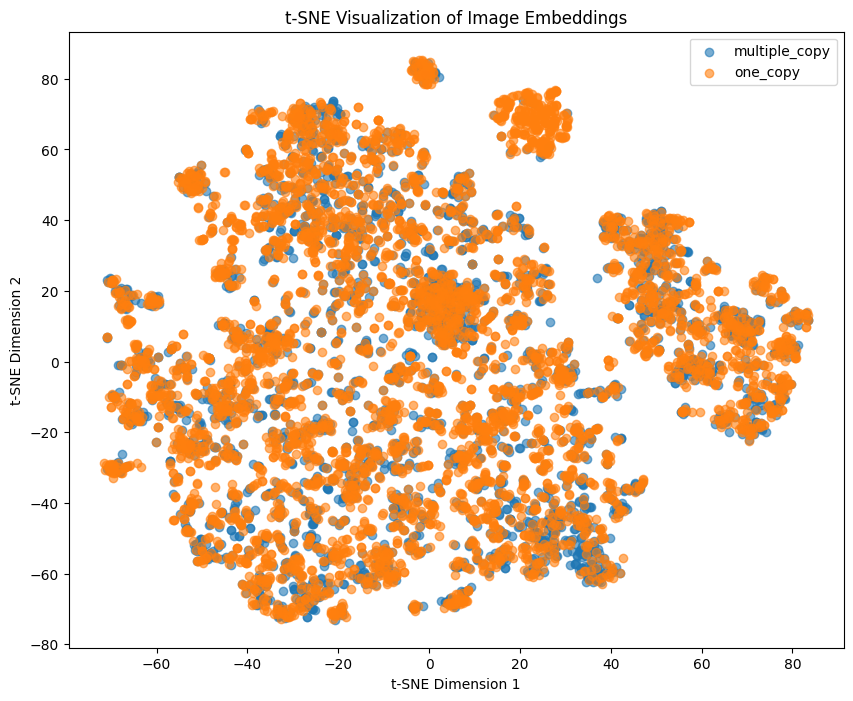

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import glob
from sklearn.manifold import TSNE
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def load_embeddings(copy_type):
    """Load image embeddings from JSON files for a given category."""
    embeddings_path = f"/teamspace/studios/this_studio/filtered_results_all/img_embeddings-clip/{copy_type}"
    embedding_files = glob.glob(os.path.join(embeddings_path, "*.json"))
    embeddings = []
    for json_file in embedding_files:
        try:
            with open(json_file, "r") as f:
                data = json.load(f)
                if isinstance(data, list):
                    embeddings.extend([np.array(embedding).flatten() for embedding in data])
                else:
                    print(f"Warning! {json_file} does not contain a list.")
        except json.JSONDecodeError as e:
            logger.warning(f"Invalid JSON in file {json_file}: {e}. Skipping.")
        except Exception as e:
            logger.warning(f"Error reading file {json_file}: {e}. Skipping.")

    logger.info(f"Total embeddings in {copy_type}: {len(embeddings)}")
    return np.array(embeddings)

embeddings_one_copy = load_embeddings("one_copy")
embeddings_multiple_copy = load_embeddings("multiple_copy")

if len(embeddings_one_copy) == 0 or len(embeddings_multiple_copy) == 0:
    logger.error("No embeddings loaded for one or both categories. Exiting.")
    exit()

# Combine embeddings and create labels
embeddings = np.vstack([embeddings_one_copy, embeddings_multiple_copy])
labels = np.array(["one_copy"] * len(embeddings_one_copy) + ["multiple_copy"] * len(embeddings_multiple_copy))

# Apply t-SNE to reduce dimensionality to 2D
logger.info("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=label, alpha=0.6)

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Image Embeddings")
plt.legend()
plt.show()